<a href="https://colab.research.google.com/github/naimaryan1/CryptoLib/blob/main/PUBLIC_yolov8_fire_and_smoke_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Complete training pipeline to train YOLOv8 classifier for fire & smoke detection based on images.**


**Motivation:** In recent years, early fire detection has become vital due to large-scale fires causing extensive financial damage and loss of life in such places as the United States, Canada, and Europe. This intercative coding environment introduces how to train deep neural networks for detecting fire and smoke, leveraging the inference of high-speed YOLO architecture. YOLO can be optimized for deployment on resource-limited edge hardware like the Raspberry Pi. The tutorial covers the entire process, including data preprocessing, model training, hyperparameter tuning, evaluating model metrics, and conducting model inference in a cloud environment.

**Step 1:**

Since we are going to run long running tasks we need a way to keep Google Collab alive even after hours of running. Even if you sign for Google Collab’s “professional” version the browser will timeout after ~30 min of inactivity.

Do this hack to keep your browser alive:
https://www.codeease.net/programming/javascript/keep-colab-from-disconnecting



In [ ]:
"""
Complete training pipeline to train YOLOv8 classifier for fire & smoke detecction based on images.

Developer: Ary Naim (anaim@unm.edu)

Advisor: Dr. Marios Pattichis (pattichi@unm.edu)

Github:

References:

1) Implementation was heavily based on:                         https://keras.io/examples/vision/yolov8/
2) Adding custom dataset via tensorflow:                        https://www.tensorflow.org/datasets/add_dataset
3) Dataset->                                                    https://github.com/gaiasd/DFireDataset
4) Attemptiong to reproduce this paper however using YOLOv8:
                                                                https://link.springer.com/article/10.1007/s00521-023-08260-2
                                                                https://www.researchgate.net/publication/361649776_An_automatic_fire_detection_system_based_on_deep_convolutional_neural_networks_for_low-power_resource-constrained_devices#fullTextFileContent


Status: Since YOLOv8 is relatively new & there are ongoing issues & improvments this is a live document.

Known Issues related Keras's implementation of YOLOv8:
1) https://github.com/keras-team/keras-cv/issues/2095
2) https://github.com/keras-team/keras-cv/issues/2442
3) KERAS YOLOv8 DOEST traditional metrics: https://github.com/keras-team/keras/issues/19416

WARNING: After running the experiment or any development change the runtime to CPU or "Disconnect & delete runtime" or
you will be charged pet hour by Google.

WARNING: No Warranties. The author makes no warranties, express or implied, with respect to code. Use at your own risk.

"""

#PLEASE READ & EXECUTE STEP BY STEP.
""" STEP 1) To avoid reconnects read: https://www.codeease.net/programming/javascript/keep-colab-from-disconnecting
"""

""" Step 2) Installation steps"""
#installations - START
!pip install tensorflow==2.15.0  # Upgrade to TensorFlow 2.  # Remove Keras 2.
!pip install keras==2.15.0  # Upgrade to Keras 2.
!pip install keras-cv
!pip install h5py
!pip install matplotlib
#installations - END

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 64.9 MB/s eta 0:00:00


**Mount your Google Drive**


In [ ]:
""" Step 3) Mount Drive"""
#MOUNT DRIVE - START
from google.colab import drive
drive.mount('/content/gdrive')
#link your path to create a symbolic link
!ln -s /content/gdrive/My\ Drive/ /mydrive
#MOUNT DRIVE - END


***Step 4: Import the required libraries***

In [ ]:
""" Step 4) Mount imports"""
#imports - START
import os
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('/content/gdrive/MyDrive/my_fire_smoke_dataset') #You & can should have this to refer to the location for your custom dataset
#import custom dataset
from my_fire_smoke_dataset import MyFireSmokeDataset
os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import tensorflow as tf
print("TF VERSION:",tf.__version__)
import keras
print("Keras VERSION:",keras.__version__)
import keras_cv
import numpy as np
from keras_cv import bounding_box
from keras_cv import visualization
import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
keras.backend.set_floatx("float32")
#imports - END

**Optional - Step 5) Add dataset to Keras**

**IMPORTANT:**

**If** you are using a precanned dataset from Keras OR you just want to run this Notbobook as is, you can skip this step #5 & go to step 6.

**Else** if you have custom dataset you have to follow this guide (https://www.tensorflow.org/datasets/add_dataset) along with our detailed instructions in the Word doc titled "Guide"

*   Before proceeding and makesure the command "tfds build --register_checksums" returns no errors.

**step 6) Declare variables & functions**

In [ ]:

"""step 6) declare variables & functions"""

#VARIABLES.
#IMPORTANT: change the labels here to reflect the actual labels you have based on your dataset.
class_ids = [
    "Fire",
     "Smoke",
]

image_size_1 = (640,640) #we are only using this tuple image_size_1. The YOLO sizes must be multiples of 32.
image_size_2 = (320,320)
image_size_3 = (160,160)

class_mapping = dict(zip(range(len(class_ids)), class_ids))


# FUNCTION DECLARATIONS - START
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    #inputs = inputs[1]
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=None,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds

#Example of getting precanned data. This is good for learning.
def get_data_train_ds():
  train_ds = load_pascal_voc(split="train", dataset="voc/2007", bounding_box_format="xyxy")
  return train_ds

#Example of getting precanned data. This is good for learning.
def get_data_eval_ds():
  eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xyxy")
  return eval_ds

#Example of getting custom data. Refer to:https://www.tensorflow.org/datasets/add_datase
def get_data_train_ds_my_fire_smoke():
  train_ds = load_pascal_voc(split="train", dataset="my_fire_smoke_dataset", bounding_box_format="xyxy")
  return train_ds

#Example of getting custom data. Refer to: https://www.tensorflow.org/datasets/add_datase
def get_data_eval_ds_my_fire_smoke():
  eval_ds = load_pascal_voc(split="test", dataset="my_fire_smoke_dataset", bounding_box_format="xyxy")
  return eval_ds

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenter_fn
#Data augmentation - END

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


def visualize_predictions(images, y_true, y_pred, bounding_box_format):
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

#load data
def load_images_from_folder(folder):
  print("load_images_from_folder - START...")
  counter_images=0
  images = []
  for filename in os.listdir(folder):
    counter_images=counter_images+1
    print("counter_images",counter_images)
    img = Image.open(os.path.join(folder, filename))
    if img is not None:
      images.append(img)
  print("load_images_from_folder - END")
  return images

def load_labels_from_folder(folder):
    print("load_images_from_folder - START...")
    labels = []
    for filename in os.listdir(folder):
          with open(os.path.join(folder, filename), 'r') as file:
            first_line = file.readline()
            if len(first_line.strip())!=0:
                label = first_line.strip().split(" ")
                labels.append(label)
            else:
                labels.append([0,0,0,0,0])
    print("load_images_from_folder - END...")
    return labels

def resize_image(image, size):
    return image.resize(size)

def convert_to_yolo_format(label, image_size):
    yolo_labels = []
    class_id = 0
    if len(label)!=0 and len(image_size)!=0:
        if label[0]!=0:
            image_width = float(image_size[0])
            image_height = float(image_size[1])
            if image_width and image_height and float(label[1]) <= image_width and  float(label[2]) <= image_height:
                class_id = int(label[0])  # Assuming the class label is the first element
                x1 = float(label[1])
                y1 = float(label[2])
                w = float(label[3])
                h = float(label[4])
                #YOLO normalises the image space to run from 0 to 1 in both x and y directions
                x1 = x1 / image_width
                y1 = y1 = image_height
                w = w / image_width
                h = h / image_height
                #add class & bounding box
                yolo_label = [class_id, x1, y1,w,h]
                yolo_labels.append(yolo_label)
        else:
            #TODO are we coming here
            yolo_labels.append(label)
    return yolo_labels

def process_dataset(image_folder, label_folder, image_size):
    print("process_dataset - START...")
    images = load_images_from_folder(image_folder)
    labels = load_labels_from_folder(label_folder)
    resized_images = []
    counter_images=0
    for img in images:
        resized_images.append(resize_image(img, image_size))
        counter_images=counter_images+1
        print("counter_images",counter_images)
    yolo_labels = []
    counter_labels=0
    for lbl in labels:
        yolo_labels.append(convert_to_yolo_format(lbl, image_size))
        counter_labels=counter_labels+1
        print("counter_labels",counter_labels)
    print("process_dataset - END")
    return resized_images, yolo_labels

def get_jpeg_files(path):
    jpeg_files = []
    for file in os.listdir(path):
        if file.endswith(".jpg") or file.endswith(".jpeg"):
            jpeg_files.append(os.path.join(path, file))
    return jpeg_files

def get_txt_files(path):
    txt_files = []
    for file in os.listdir(path):
        if file.endswith(".txt"):
          txt_files.append(os.path.join(path, file))
    return txt_files

def prepare_yolo_dataset(data_path, image_size):
    print("prepare_yolo_dataset - START...")
    return process_dataset(os.path.join(data_path, 'images'), os.path.join(data_path, 'labels'),image_size)
    print("prepare_yolo_dataset - END")

# Create a function to read the bounding boxes from a text file
def read_bounding_boxes(label_file):
  print("read_bounding_boxes - START")
  with open(label_file, 'r') as f:
    bounding_boxes = []
    for line in f:
      if not line.strip():
        # Empty line, set class to 0 and bounding box to 0,0,0,0
        bounding_boxes.append({
            'class': 0,
            'x': 0.0,
            'y': 0.0,
            'width': 0.0,
            'height': 0.0
        })
      else:
        class_name, x, y, w, h = line.split()
        bounding_boxes.append({
            'class': class_name,
            'x': float(x),
            'y': float(y),
            'width': float(w),
            'height': float(h)
        })
  print("read_bounding_boxes - END")
  return bounding_boxes

# Create a function to load an image and its corresponding bounding boxes
def load_image_and_bounding_boxes(image_file, label_file):
  print("load_image_and_bounding_boxes - START")
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image,
    size=image_size_1,
    method='nearest',
    preserve_aspect_ratio=False,
    antialias=False,
    name=None)
  bounding_boxes = read_bounding_boxes(label_file)
  print("load_image_and_bounding_boxes - END")
  return image, bounding_boxes


def shuffle_generator(image, bounding,label, seed):
    idx = np.arange(len(image))
    np.random.default_rng(seed).shuffle(idx)
    for i in idx:
        yield image[i],bounding[i],label[i]
# FUNCTION DECLARATIONS - END

**step 7) Start the experiment & load data**

Noe that we have imported all the required imports and declared all the required functions. Lets run the experiment.

**YOU NEED A RUNTIME WITH A GPU.** Makesure to switch the runtime to a GPU that you can afford (start with L4). You may need re-run previous steps as the runtime is restarted.

You should start seeing the dataset being loaded. This will take a while even though we are only using 500 images which is not enough for building an accurate model.

*Note:* If you want to load the entire 20,000 images open the Python file title “my_fire_smoke_dataset.py” and make an update in the function.

GET DATA - START 


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

bounding_box: {'class': 'Fire', 'x': 0.4852941176470588, 'y': 0.25416666666666665, 'width': 0.8823529411764706, 'height': 0.45833333333333337}
_generate_examples(), DATA: {'class': 'Fire', 'x': 0.4852941176470588, 'y': 0.25416666666666665, 'width': 0.8823529411764706, 'height': 0.45833333333333337}
bounding_box: {'class': 'Fire', 'x': 0.41150000000000003, 'y': 0.33066666666666666, 'width': 0.8130000000000001, 'height': 0.6453333333333333}
_generate_examples(), DATA: {'class': 'Fire', 'x': 0.41150000000000003, 'y': 0.33066666666666666, 'width': 0.8130000000000001, 'height': 0.6453333333333333}
bounding_box: {'class': 'Fire', 'x': 0.5024509803921569, 'y': 0.2, 'width': 0.8970588235294118, 'height': 0.35000000000000003}
_generate_examples(), DATA: {'class': 'Fire', 'x': 0.5024509803921569, 'y': 0.2, 'width': 0.8970588235294118, 'height': 0.35000000000000003}
bounding_box: {'class': 'Fire', 'x': 0.3802931596091205, 'y': 0.2305194805194805, 'width': 0.7312703583061889, 'height': 0.430735930

Shuffling /root/tensorflow_datasets/my_fire_smoke_dataset/1.0.0.incomplete4T6HUV/my_fire_smoke_dataset-train.t…

Generating test examples...: 0 examples [00:00, ? examples/s]

bounding_box: {'class': 'Fire', 'x': 0.30390625000000004, 'y': 0.4777777777777778, 'width': 0.1484375, 'height': 0.1388888888888889}
_generate_examples(), DATA: {'class': 'Fire', 'x': 0.30390625000000004, 'y': 0.4777777777777778, 'width': 0.1484375, 'height': 0.1388888888888889}
bounding_box: {'class': 'Smoke', 'x': 0.7296875, 'y': 0.3611111111111111, 'width': 0.08125, 'height': 0.09444444444444444}
_generate_examples(), DATA: {'class': 'Smoke', 'x': 0.7296875, 'y': 0.3611111111111111, 'width': 0.08125, 'height': 0.09444444444444444}
bounding_box: {'class': 'Fire', 'x': 0.5041666666666667, 'y': 0.5083333333333333, 'width': 0.9638888888888889, 'height': 0.9111111111111111}
_generate_examples(), DATA: {'class': 'Fire', 'x': 0.5041666666666667, 'y': 0.5083333333333333, 'width': 0.9638888888888889, 'height': 0.9111111111111111}
bounding_box: {'class': 'Fire', 'x': 0.5875, 'y': 0.3472222222222222, 'width': 0.8125, 'height': 0.6666666666666667}
_generate_examples(), DATA: {'class': 'Fire', '

Shuffling /root/tensorflow_datasets/my_fire_smoke_dataset/1.0.0.incomplete4T6HUV/my_fire_smoke_dataset-test.tf…

Dataset my_fire_smoke_dataset downloaded and prepared to /root/tensorflow_datasets/my_fire_smoke_dataset/1.0.0. Subsequent calls will reuse this data.
GET DATA - END
#PREPROCESS - START
AUGMENTATION - START
RESIZING - START


100%|██████████| 646/646 [00:00<00:00, 878kB/s]
100%|██████████| 45.6M/45.6M [00:04<00:00, 10.8MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


TRAINING - START
Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1187246   ['input_2[0][0]']             
                             192),                        4                                       
                              'P4': (None, None, None,                                            
                             384),                                                                
                              'P5': (None, None, None,                                            
                             576)}                                 

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


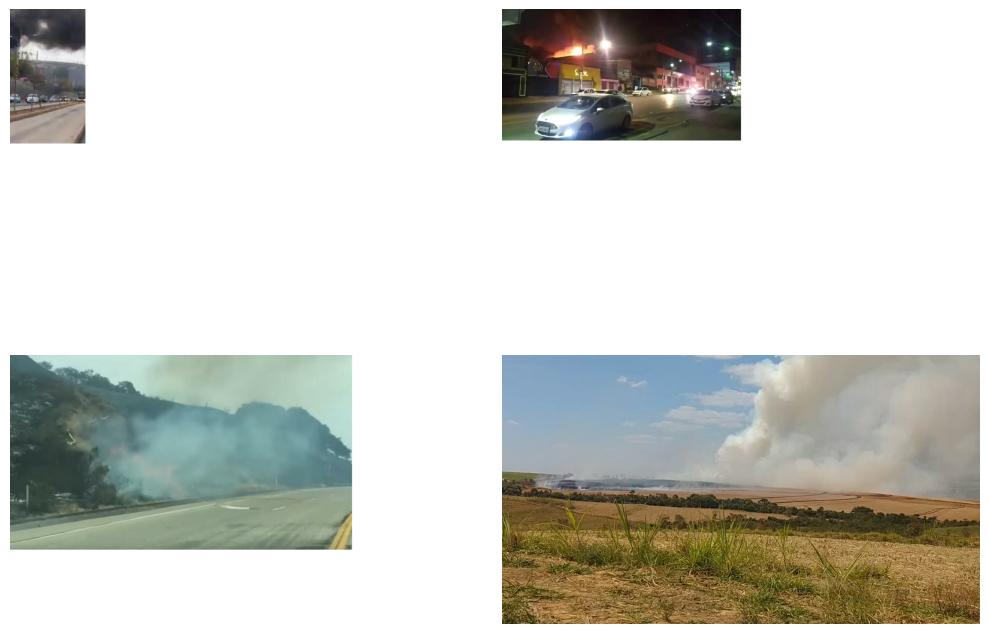

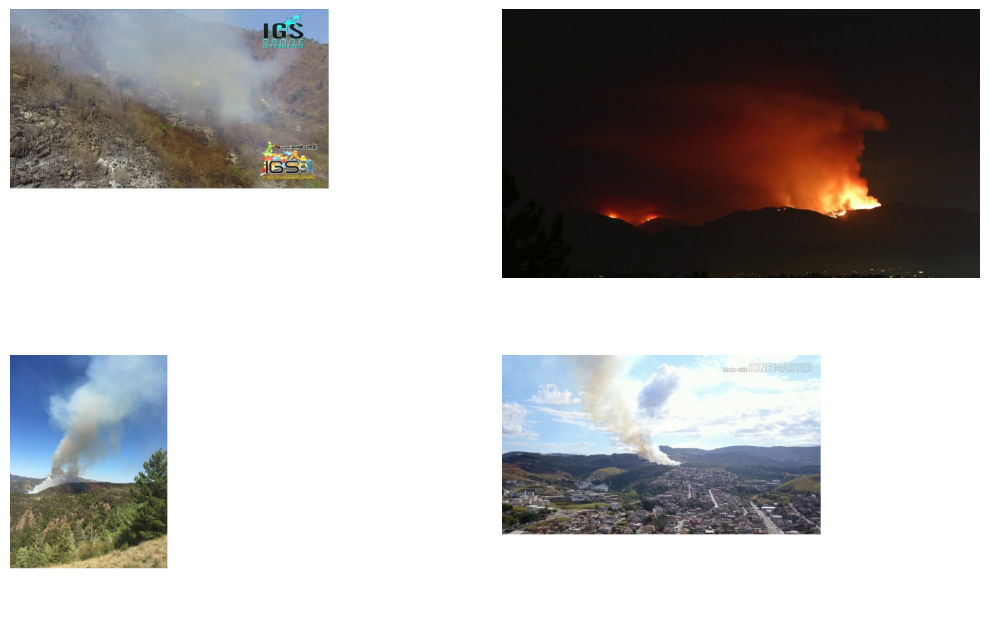

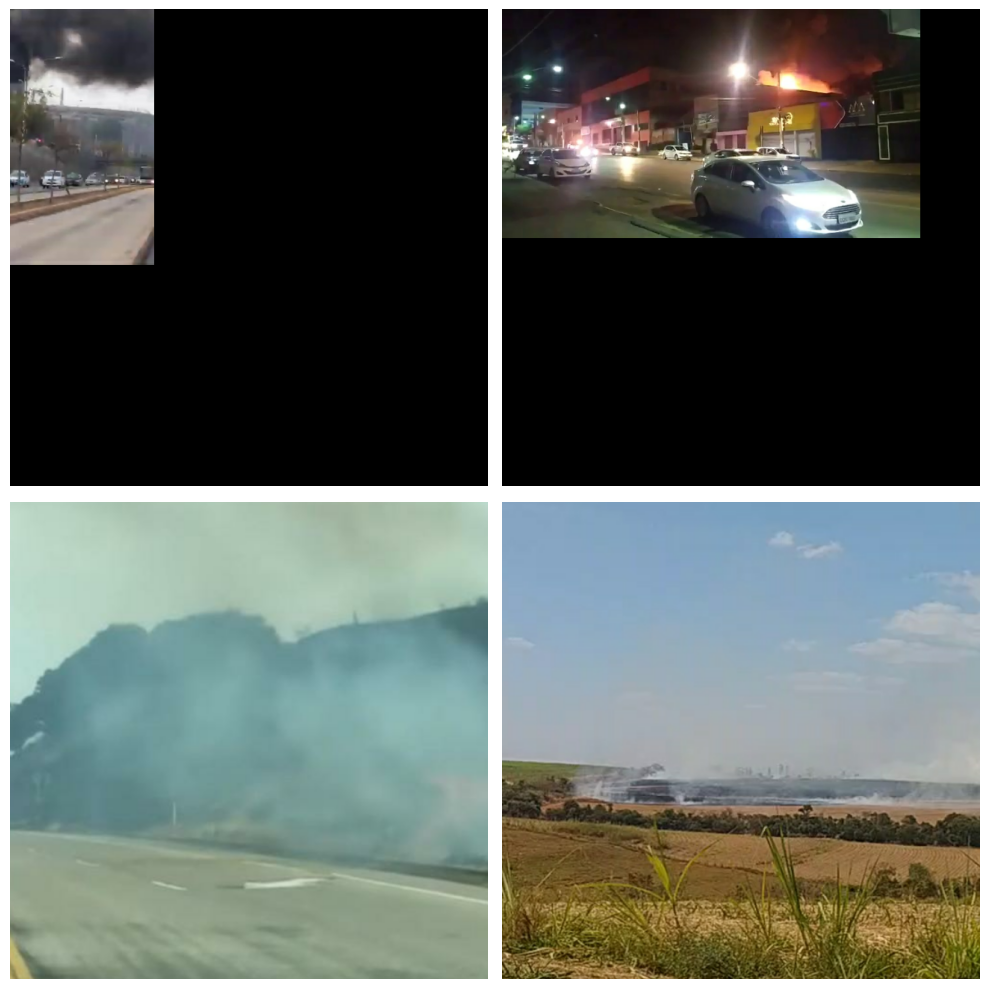

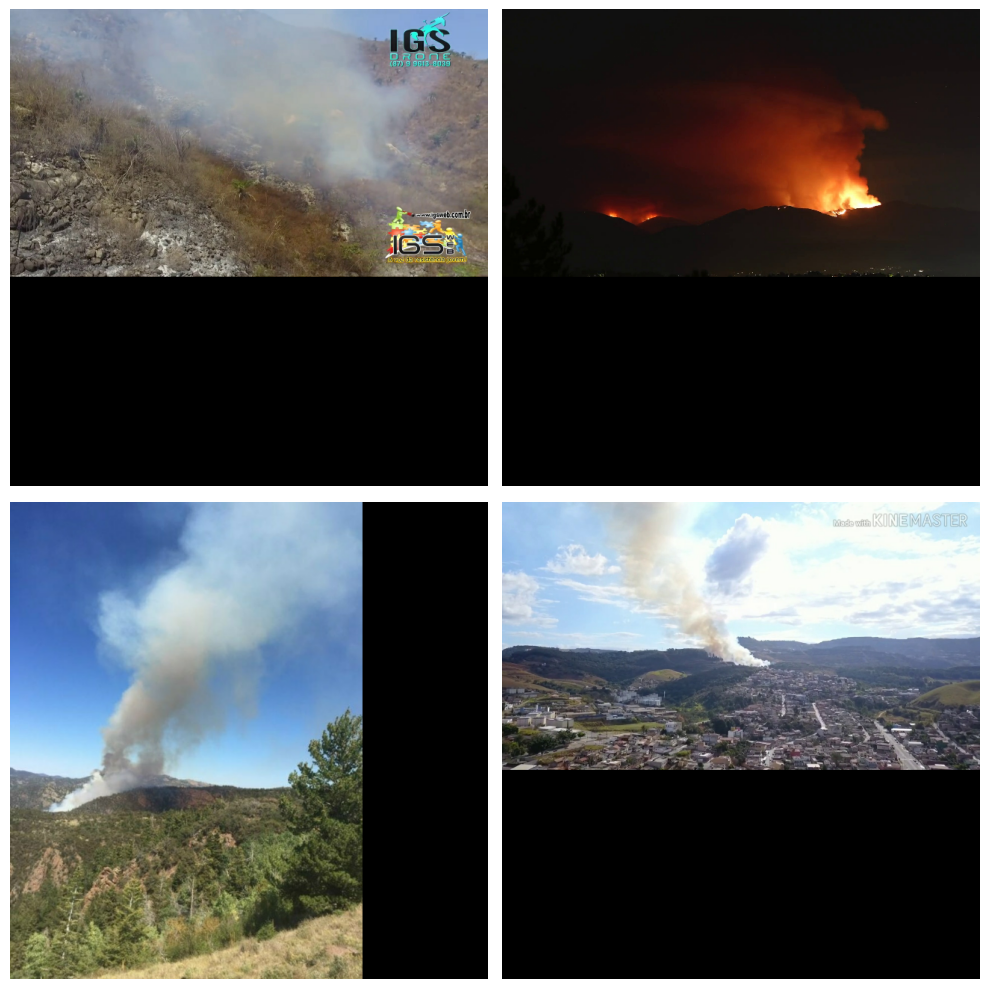

In [ ]:
"""step 7) Start the experiment & load data"""
#PARAMATERS
BATCH_SIZE = 4
#hyperparameters - START
#hyperparameters
LEARNING_RATE = 0.005  #try 0.001 to 0.005
EPOCHS = 50 # 50 is not enough, the original paper ran epoches frpm 5,000 to 30,000
MOMENTUM = 0.9
#hyperparameters - END

#GET DATA
print("GET DATA - START ")
#original
train_ds = get_data_train_ds_my_fire_smoke()
eval_ds = get_data_eval_ds_my_fire_smoke()
# #my_fire_smoke
# train_ds = get_data_train_ds()
# eval_ds = get_data_eval_ds()
print("GET DATA - END")

#PREPROCESS - START
print("#PREPROCESS - START")
# train_ds = train_ds.shuffle(BATCH_SIZE)
# eval_ds = eval_ds.shuffle(BATCH_SIZE)

train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# #VISUALIZATION - optional
visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)
visualize_dataset(
      eval_ds,
      bounding_box_format="xyxy",
      value_range=(0, 255),
      rows=2,
      cols=2,
      # If you are not running your experiment on a local machine, you can also
      # make `visualize_dataset()` dump the plot to a file using `path`:
      # path="eval.png"
  )

augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
    keras_cv.layers.JitteredResize(
        target_size=image_size_1, scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
    ),
]
print("AUGMENTATION - START")
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

inference_resizing = keras_cv.layers.Resizing(
   image_size_1[0],image_size_1[1], bounding_box_format="xyxy", pad_to_aspect_ratio=True
)
print("RESIZING - START")
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    eval_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)
#In order to be TPU compatible, bounding box Tensors need to be Dense instead of Ragged.
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)
#PREPROCESS - END

#OPTIMIZER - START
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM, global_clipnorm=10.0
)
#OPTIMIZER - END


#LOSS FUNCTION - START
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
#LOSS FUNCTION - END

#DEFINE MODEL
#YOLOv8, references: https://keras.io/api/keras_cv/models/backbones/yolo_v8/
#A medium YOLOV8 backbone pretrained on COCO
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_ids),
    bounding_box_format="xyxy",
    backbone=keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"
    ),
    fpn_depth=2
)

#TRAINING - START
#the KerasCV API to construct an untrained YOLOV8Detector model
print("TRAINING - START")

model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

model.summary()

#METRICS CALL BACK
metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds, bounding_box_format="xyxy"
)

model.fit(
    train_ds,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=EPOCHS,
    callbacks=[metrics_callback],
)

#Save the model to disk to avoid having to rebuild everytime you want to use the model
model_path = F"/content/gdrive/My Drive/ece551/week2_model/YOLOV8_model.keras"
model.save(model_path)

**Inference - Lets load & use the model**

1/1 [==============================] - 3s 3s/step


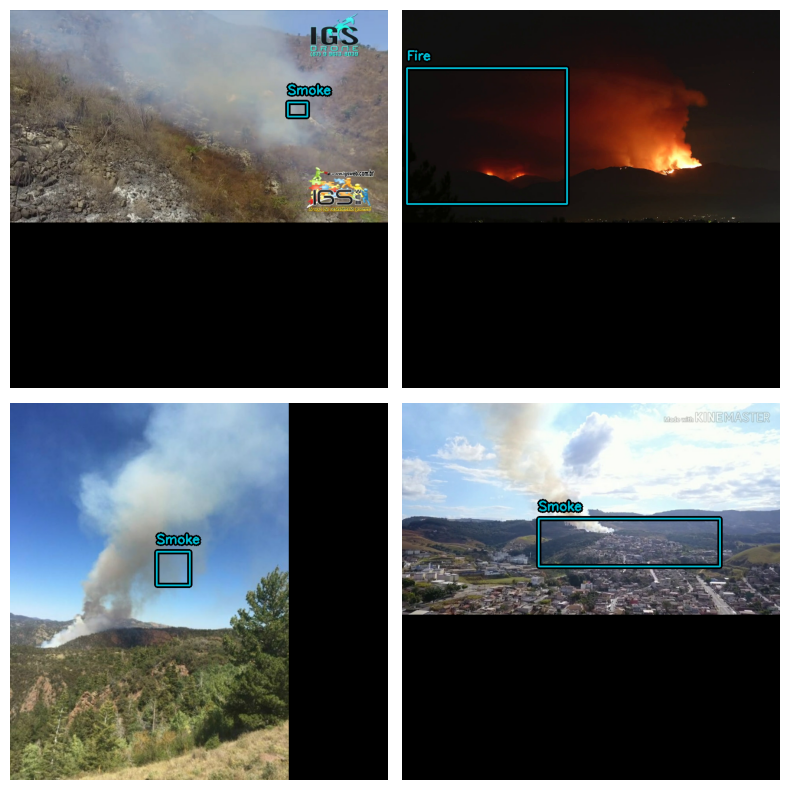

1/1 [==============================] - 3s 3s/step
 pa_fpn_p4p5_pre_0_2_conv (  (None, None, None, 192)      331776    ['pa_fpn_p4p5_pre_0_2_pad[0][0
 Conv2D)                                                            ]']                           
                                                                                                  
 pa_fpn_p4p5_pre_0_2_bn (Ba  (None, None, None, 192)      768       ['pa_fpn_p4p5_pre_0_2_conv[0][
 tchNormalization)                                                  0]']                          
                                                                                                  
 pa_fpn_p4p5_pre_0_2 (Activ  (None, None, None, 192)      0         ['pa_fpn_p4p5_pre_0_2_bn[0][0]
 ation)                                                             ']                            
                                                                                                  
 pa_fpn_p4p5_pre_1_1_pad (Z  (None, None, None, 192)      0

In [ ]:
#INFERENCE - Lets use the mode

loaded_model = keras.saving.load_model(model_path)
model = loaded_model
if model is not None:
    print("Model loaded from disk")
else:
    print("Failed to load model from disk")

if model is not None:
    model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

#LOAD MODEL - END
#INFERENCE
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
images, y_true = next(iter(visualization_ds.take(1)))
y_pred = model.predict(images)

#VISUALIZE PREDICTION
visualize_predictions(images, y_true, y_pred,bounding_box_format="xyxy")

model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")

#METRICS CALL BACK
print(metrics_callback.model.summary())

# **This is work in progress.**

**There are known issues with Keras's implementation:**

1) https://github.com/keras-team/keras-cv/issues/2095

Wideli expected metrics are not being reported back.

KERAS YOLOv8 DOEST traditional metrics: https://github.com/keras-team/keras/issues/19416

2) https://github.com/keras-team/keras-cv/issues/2442

Bad performance when compared to Ultralytics. This is probably due to problem #1 as we have no standard metrics.

3) Furthermore, we should try freezing the layers and comparing the performnance when issues #1 & #2 are fixed by Keras.